数据集形状: (1757, 26)
缺失值统计:
Environment        1757
Unnamed: 24        1757
Trans Mode         1757
Grade              1757
Crop               1757
Storage            1757
Appearance         1757
Condition          1757
Quality            1757
Type               1712
Unnamed: 25        1654
Origin District    1626
Unit of Sale       1595
Sub Variety        1461
Color               616
Item Size           279
Mostly High         103
Mostly Low          103
Variety               5
Origin                3
High Price            0
Low Price             0
Date                  0
Repack                0
Package               0
City Name             0
dtype: int64
随机森林模型:


C:\Users\86182\AppData\Local\Temp\ipykernel_19624\1290247112.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # 使用 errors='coerce' 将无法解析的日期设置为 NaT


Mean Squared Error: 278.13050036271983
R² Score: 0.9627163544232139


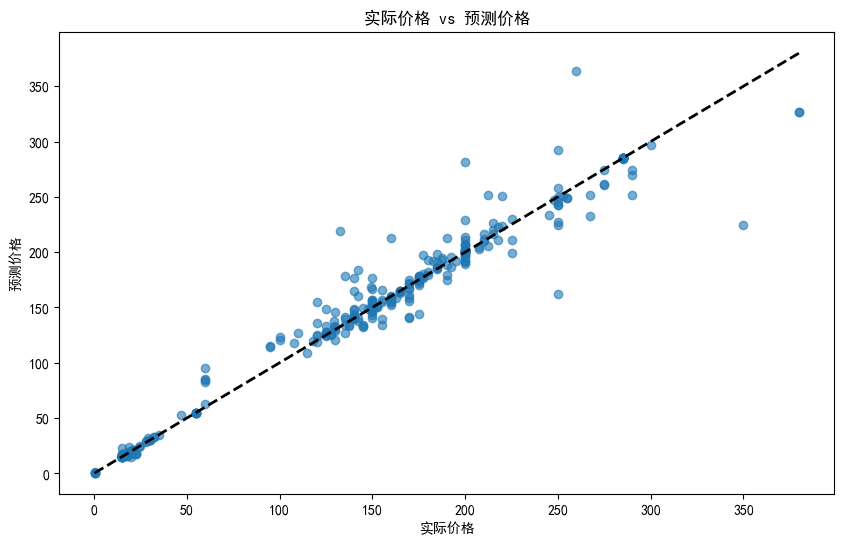

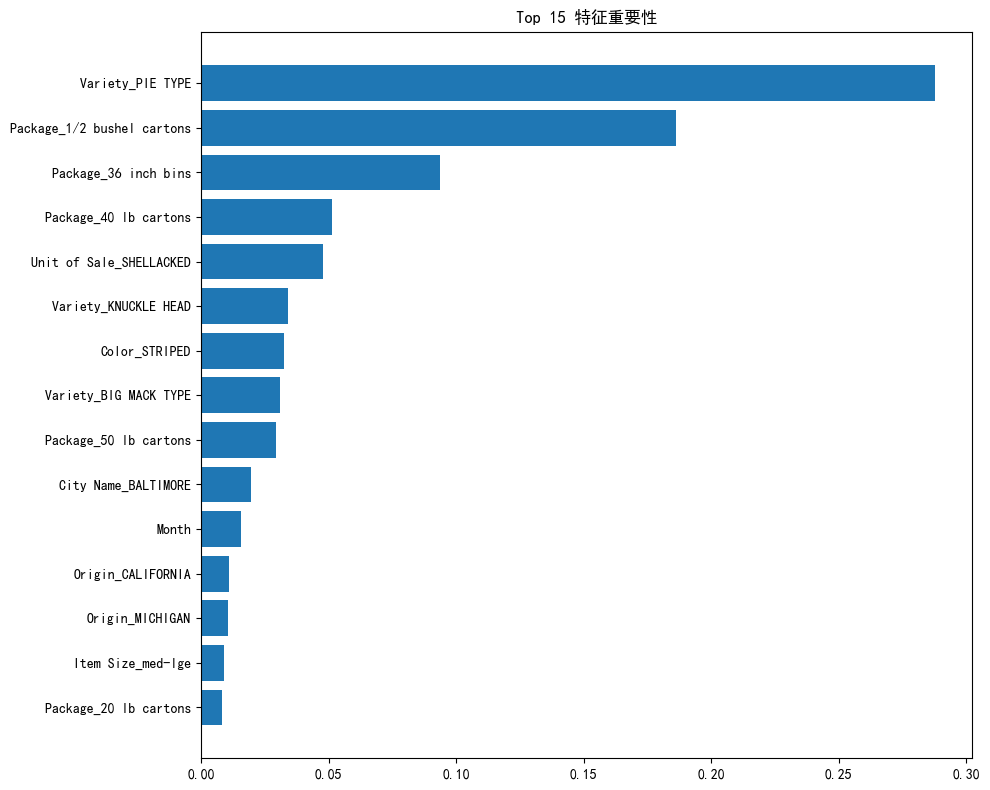

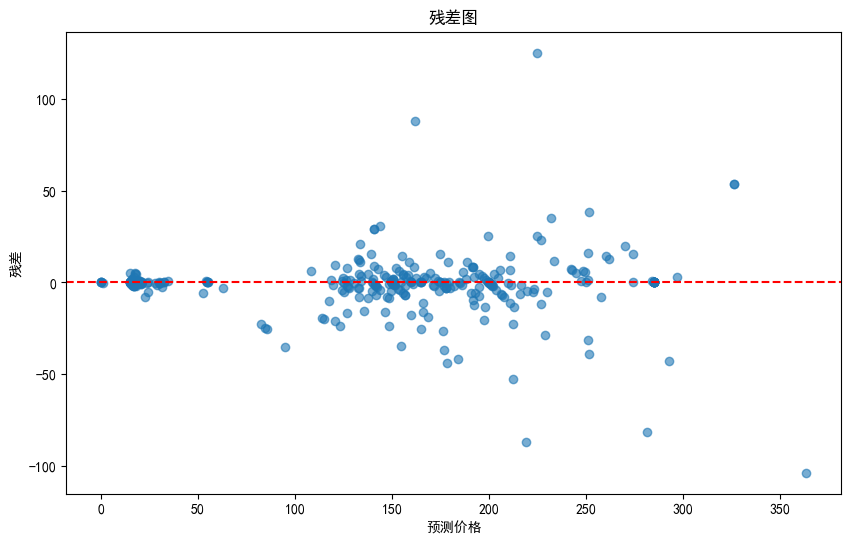

超参数调优随机森林模型:
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


D:\ddd\envs\senlin\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
376 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ddd\envs\senlin\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ddd\envs\senlin\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "D:\ddd\envs\senlin\lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "D:\ddd\envs\senlin\lib\site

Best parameters: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best MSE: 553.5419401021336
Best Random Forest Mean Squared Error: 347.422913566202
Best Random Forest R² Score: 0.9534276436501429


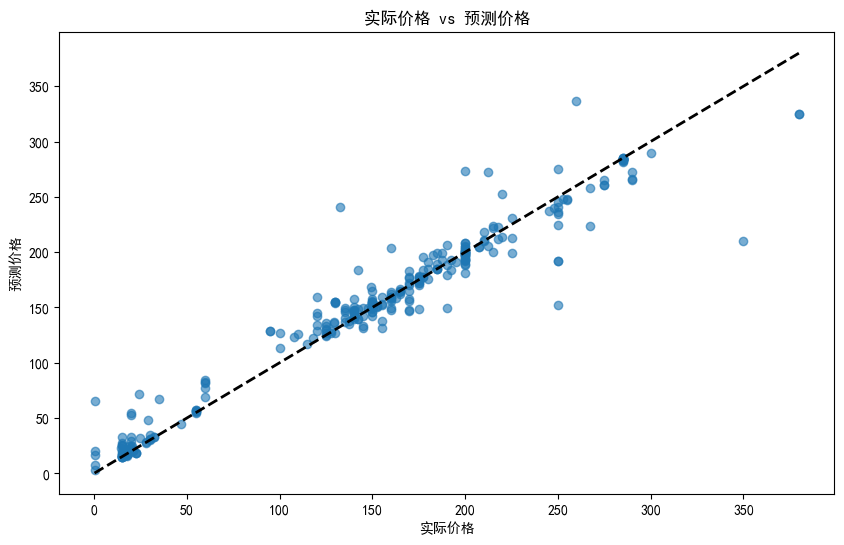

梯度提升模型:
Mean Squared Error: 669.5097294213606
R² Score: 0.9102516141544978


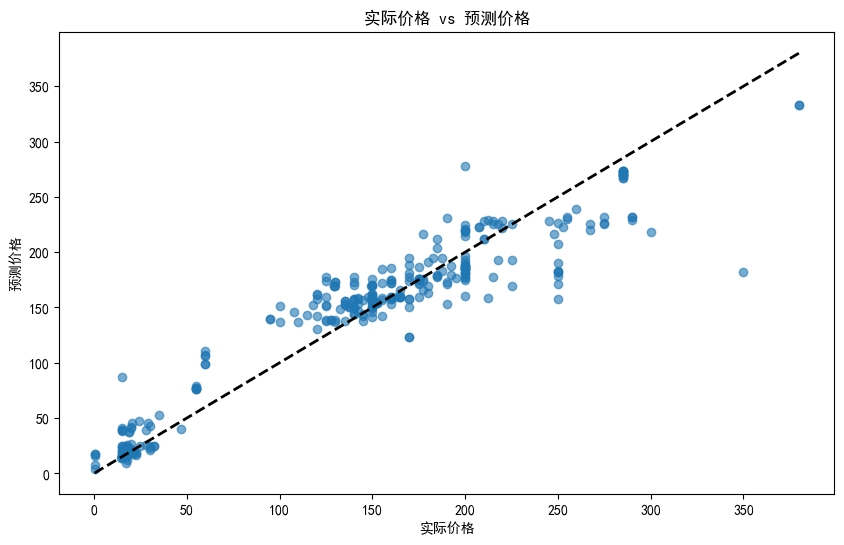

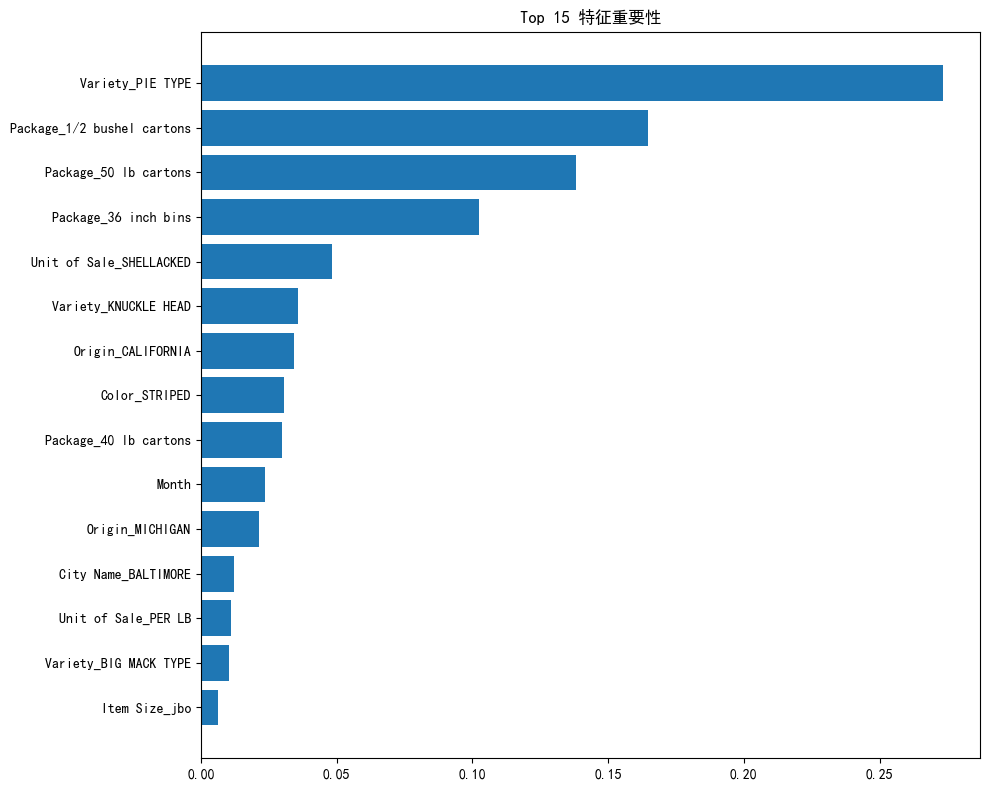

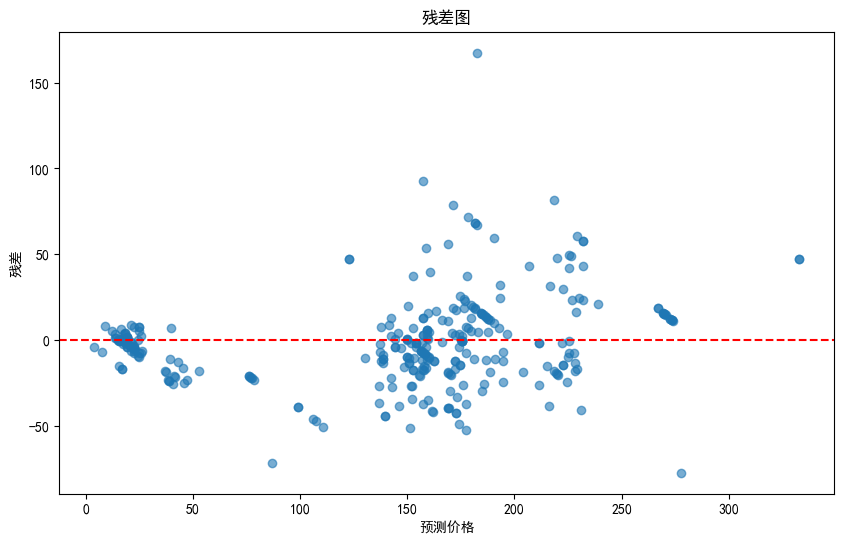

超参数调优梯度提升模型:
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best MSE: 424.8897877472133
Best Gradient Boosting Mean Squared Error: 244.2674706766907
Best Gradient Boosting R² Score: 0.9672557242345923


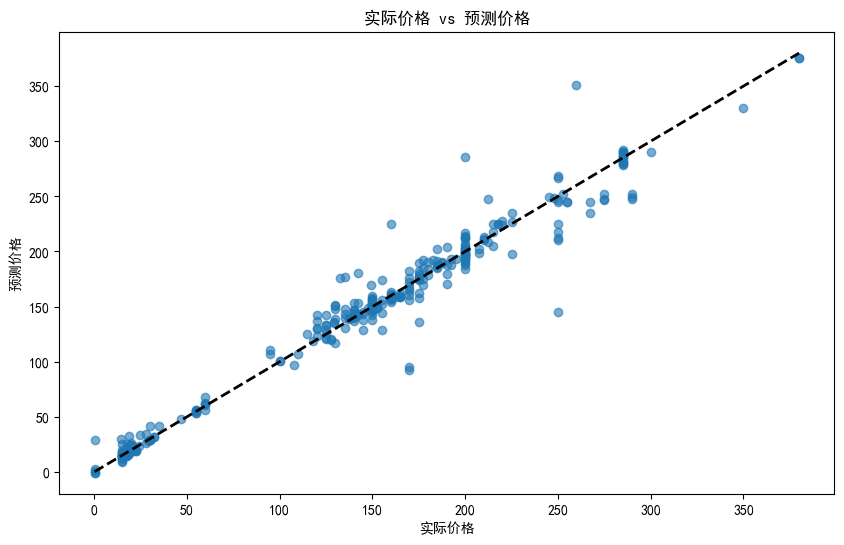

In [3]:
# 加载数据
def load_data(file_path):
    return pd.read_csv(file_path)

# 设置中文显示
def set_chinese_font():
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

# 数据预处理
def preprocess_data(df):
    # 特征选择
    features = ['City Name', 'Package', 'Variety', 'Origin', 'Item Size', 'Color', 'Unit of Sale']
    df = df[features + ['Date', 'Mostly Low', 'Mostly High']].copy()
    
    # 日期特征工程
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # 使用 errors='coerce' 将无法解析的日期设置为 NaT
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    
    # 目标变量创建
    df['Avg_Price'] = (df['Mostly Low'] + df['Mostly High']) / 2
    
    # 缺失值处理
    categorical_features = ['City Name', 'Package', 'Variety', 'Origin', 'Item Size', 'Color', 'Unit of Sale']
    numerical_features = ['Month', 'Week']
    
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[categorical_features] = imputer_cat.fit_transform(df[categorical_features])
    
    imputer_num = SimpleImputer(strategy='mean')
    df[numerical_features] = imputer_num.fit_transform(df[numerical_features])
    
    # 处理 Avg_Price 中的缺失值
    df = df.dropna(subset=['Avg_Price'])
    
    # 异常值处理
    Q1 = df['Avg_Price'].quantile(0.25)
    Q3 = df['Avg_Price'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df['Avg_Price'] < (Q1 - 1.5 * IQR)) | (df['Avg_Price'] > (Q3 + 1.5 * IQR)))]
    
    return df

# 创建预处理器
def create_preprocessor(df):
    categorical_features = ['City Name', 'Package', 'Variety', 'Origin', 'Item Size', 'Color', 'Unit of Sale']
    numerical_features = ['Month', 'Week']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    return preprocessor

# 创建随机森林模型管道
def create_random_forest_pipeline(preprocessor):
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    return model

# 创建梯度提升模型管道
def create_gradient_boosting_pipeline(preprocessor):
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])
    return model

# 模型训练和评估
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    # 再次检查并处理 X_train 和 X_test 中的缺失值
    X_train = X_train.dropna()
    X_test = X_test.dropna()
    y_train = y_train[X_train.index]  # 确保 y_train 与 X_train 的索引一致
    y_test = y_test[X_test.index]     # 确保 y_test 与 X_test 的索引一致
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')
    return model, y_pred

# 主函数，用于协调各模块
def main(file_path):
    df = load_data(file_path)
    set_chinese_font()
    print(f"数据集形状: {df.shape}")
    print(f"缺失值统计:\n{df.isnull().sum().sort_values(ascending=False)}")
    
    # 数据预处理
    df = preprocess_data(df)
    
    # 重新定义X和y
    X = df.drop(columns=['Avg_Price'])
    y = df['Avg_Price']
    
    # 数据划分
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 创建预处理器
    preprocessor = create_preprocessor(df)
    
    # 创建随机森林模型管道
    rf_model = create_random_forest_pipeline(preprocessor)
    
    # 训练和评估随机森林模型
    print("随机森林模型:")
    rf_model, rf_y_pred = train_and_evaluate_model(rf_model, X_train, X_test, y_train, y_test)
    
    # 绘制随机森林模型的实际值与预测值对比图
    plot_actual_vs_predicted(y_test, rf_y_pred)
    
    # 绘制随机森林模型的特征重要性
    categorical_features = ['City Name', 'Package', 'Variety', 'Origin', 'Item Size', 'Color', 'Unit of Sale']
    numerical_features = ['Month', 'Week']
    plot_feature_importance(rf_model, categorical_features, numerical_features)
    
    # 绘制随机森林模型的残差图
    plot_residuals(y_test, rf_y_pred)
    
    # 超参数调优随机森林模型
    print("超参数调优随机森林模型:")
    best_rf_model = tune_hyperparameters(rf_model, X_train, y_train)
    
    # 使用最佳参数的随机森林模型进行预测
    best_rf_y_pred = best_rf_model.predict(X_test)
    
    # 评估最佳随机森林模型
    mse_best_rf = mean_squared_error(y_test, best_rf_y_pred)
    r2_best_rf = r2_score(y_test, best_rf_y_pred)
    print(f'Best Random Forest Mean Squared Error: {mse_best_rf}')
    print(f'Best Random Forest R² Score: {r2_best_rf}')
    
    # 绘制最佳随机森林模型的实际值与预测值对比图
    plot_actual_vs_predicted(y_test, best_rf_y_pred)
    
    # 创建梯度提升模型管道
    gb_model = create_gradient_boosting_pipeline(preprocessor)
    
    # 训练和评估梯度提升模型
    print("梯度提升模型:")
    gb_model, gb_y_pred = train_and_evaluate_model(gb_model, X_train, X_test, y_train, y_test)
    
    # 绘制梯度提升模型的实际值与预测值对比图
    plot_actual_vs_predicted(y_test, gb_y_pred)
    
    # 绘制梯度提升模型的特征重要性
    plot_feature_importance(gb_model, categorical_features, numerical_features)
    
    # 绘制梯度提升模型的残差图
    plot_residuals(y_test, gb_y_pred)
    
    # 超参数调优梯度提升模型
    print("超参数调优梯度提升模型:")
    param_grid_gb = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 4, 5],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
    grid_search_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grid_search_gb.fit(X_train, y_train)
    print(f'Best parameters: {grid_search_gb.best_params_}')
    print(f'Best MSE: {-grid_search_gb.best_score_}')
    
    # 使用最佳参数的梯度提升模型进行预测
    best_gb_model = grid_search_gb.best_estimator_
    best_gb_y_pred = best_gb_model.predict(X_test)
    
    # 评估最佳梯度提升模型
    mse_best_gb = mean_squared_error(y_test, best_gb_y_pred)
    r2_best_gb = r2_score(y_test, best_gb_y_pred)
    print(f'Best Gradient Boosting Mean Squared Error: {mse_best_gb}')
    print(f'Best Gradient Boosting R² Score: {r2_best_gb}')
    
    # 绘制最佳梯度提升模型的实际值与预测值对比图
    plot_actual_vs_predicted(y_test, best_gb_y_pred)

# 如果在 Jupyter Notebook 中运行，取消注释下面这行
main('US-pumpkins.csv')